In [1]:
import numpy as np 
import pandas as pd 
import warnings
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import shap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
!pip install Wittgenstein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 2.1 MB/s eta 0:00:00


In [3]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 110195 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.14) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for ta-lib: filename=TA_Lib-0.4.28-cp310-cp310-linux_x86_64.whl size=500067 sha256=ebf60c64388710dae3b23cdfb14fd82917e042569fa696228c9bb20c30f033bf
  Stored in direc

In [4]:
#Open-Source library for technical analysis of time series and trading data.
from talib import RSI, SMA, EMA, MFI, ATR, ADX, WILLR, OBV, CCI
# Wittgenstein library is used for the RIPPER algorithm
import wittgenstein as lw

In [5]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Helper functions for submitting a submission file for evaluation on the Leaderboard and plotting stock data

In [6]:
def save_predictions(predictions, df_test, output_file_path):
    """
    Saves predictions to a CSV file in the working directory.

    Args:
    - predictions (array-like): Predicted values.
    - df_test (DataFrame): DataFrame containing 'Id' column.
    - output_file_path (str): Path to save the output CSV file.
    """
    output = pd.DataFrame({'Id': df_test['Id'], 'Target': predictions})
    output.to_csv(output_file_path, index=False)

In [7]:
def plot_stock_data(stock_data, features, stock_name):
    '''
    Function to create a line plot for a single stock.

    Parameters:
        - stock_data (DataFrame): DataFrame containing stock data, with 'Date' as index.
        - features (list of str): List of features to plot on the y-axis.
        - stock_name (str): Name of the stock.

    Returns:
        - None (displays the plot).
    '''
    # Set figure size
    plt.figure(figsize=(20, 10))
    
    # Plot each feature
    for feature in features:
        plt.plot(stock_data['Date'], stock_data[feature], label=feature)
        
    ax = plt.gca()
    
    if(len(stock_data)>100):
        # Set x-axis ticks to display every 2 months
        ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=2))
    else:
        # Set x-axis ticks to display every day
        ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=1))
    plt.xticks(rotation=45)
    
    # Add legend
    plt.legend()
    
    # Determine date range considering available data
    min_date = stock_data.loc[stock_data['Open'].notnull(), 'Date'].min()
    max_date = stock_data.loc[stock_data['Open'].notnull(), 'Date'].max()
    
    date_range = f"{min_date} to {max_date}"
      
    # Add title
    plt.title(f"Stock Data for {stock_name} ({date_range})")
    # Show plot
    plt.tight_layout()
    plt.show()

# Collection of initial data

In [8]:
# File path
file_path = "/kaggle/input/dapprojekt24-1/"

# Load training and test datasets
df_train = pd.read_csv(f"{file_path}train.csv")
df_test = pd.read_csv(f"{file_path}test.csv")

# Data validation

In [9]:
# Drop rows with missing values in specific columns
df_train = df_train.dropna(subset=['Adj Close', 'Close', 'High', 'Low', 'Open'])

Removing rows for stocks that have missing values in the columns '*Adj Close*', '*Close*', '*High*', '*Low*', '*Open*' because the values of these stocks were introduced to the market later. Recording for each stock in this dataset begins from the date 04/01/2010 and extends until 31/12/2019. They might not have been listed on the exchange on 04/01/2010 but rather later.

In [10]:
# Identifying rows where the symbol is 'MMM' and interpolating missing values in the 'Volume' column
mask_MMM = df_train['Symbol'] == 'MMM'
df_train.loc[mask_MMM, 'Volume'] = df_train.loc[mask_MMM, 'Volume'].interpolate(method='spline', order=3)

Imputing 16 missing values in the '*Volume*' column using the LOCF interpolation. 

In [11]:
# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Replace negative values with NaN
df_train.loc[df_train['High'] < 0, 'High'] = float('nan')

# Apply KNNImputer on 'High' column for 'BALL' symbol
df_train.loc[df_train['Symbol'] == 'BALL', 'High'] = imputer.fit_transform(df_train.loc[df_train['Symbol'] == 'BALL', ['High']])

Replacing impossible values such as negative stock prices found in the '*High*' column using the KNN Imputer.

In [12]:
# Group data by 'Symbol'
grouped_test_data = df_test.groupby('Symbol')

# Iterate over groups
for symbol, group in grouped_test_data:
    # Select features for imputation
    features_to_impute = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    
    # Impute missing values for the current group
    imputed_values = imputer.fit_transform(group[features_to_impute])
    
    # Replace NaN values in the group with imputed values
    group[features_to_impute] = imputed_values
    
    # Update the original DataFrame with the imputed values
    df_test.loc[group.index, features_to_impute] = imputed_values

# Check if there are any missing values after imputation
if df_test.isna().sum().sum() == 0:
    print("Missing values have been successfully imputed.")
else:
    print("There are still missing values in the dataset.")

Missing values have been successfully imputed.


Imputing missing values in df_test using KNN imputer while considering stocks that have missing values and looking at their nearest neighbors.


# First Cross-validation function

In [13]:
def cross_valid_func(data,features):
    """
    Perform cross-validation on a given dataset using several machine learning models.
    
    Parameters:
        data (DataFrame): The dataset containing both features and target variable.
        features (list): List of feature names to be used in the models.
    
    Returns:
        None
    """
    # Define models
    models = {
        'GaussianNB': GaussianNB(),
        'LogisticRegression': LogisticRegression(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=100, n_jobs=-1),
        'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=100, n_jobs=-1),
        'XGBClassifier': XGBClassifier()
    }
       
    # Initialize KFold cross-validator
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Print header
    print("Algorithm\t\tFold 1\tFold 2\tFold 3\tFold 4\tFold 5\tAverage")
    
    # Iterate over models
    for name, model in models.items():
        # Perform cross-validation
        scores = cross_val_score(model, data[features], data['Target'], cv=kf, scoring='f1')
        
        # Calculate average score
        avg_score = np.mean(scores)
        
        # Print model scores
        print("{:<20}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(name, scores[0], scores[1], scores[2], scores[3], scores[4], avg_score))

In [14]:
features_one = ['Volume', 'Adj Close']
cross_valid_func(df_train, features_one)

Algorithm		Fold 1	Fold 2	Fold 3	Fold 4	Fold 5	Average
GaussianNB          	0.88	0.87	0.88	0.88	0.88	0.88
LogisticRegression  	0.88	0.88	0.88	0.88	0.88	0.88
RandomForestClassifier	0.85	0.85	0.85	0.85	0.85	0.85
ExtraTreesClassifier	0.85	0.85	0.85	0.85	0.85	0.85
XGBClassifier       	0.88	0.88	0.88	0.88	0.88	0.88


This table presents the results of evaluating the performance of various machine learning algorithms across 5 folds in the cross-validation process. 

GaussianNB and LogisticRegression: Both algorithms achieve consistent F1 scores of 0.88 in each fold, indicating stable performance across all subsets of the data.

RandomForestClassifier and ExtraTreesClassifier: Both algorithms also achieve consistent F1 scores of 0.85 in each fold. Although the scores are slightly lower compared to GaussianNB and LogisticRegression, they are still quite stable and not subject to significant variations.

XGBClassifier: This algorithm also achieves consistent F1 scores of 0.88 in each fold, similar to GaussianNB and LogisticRegression. This suggests that XGBoost performs well on this dataset.

Average scores: The average F1 scores for all algorithms are identical to their scores in each individual fold. This indicates that the algorithms are consistent in their performance across all folds, which is a good sign and suggests that the models generalize well to unseen data.

In [15]:
X_1= df_train[features_one].values
y_1 = df_train['Target'].values

# Training the best model on the entire training set
best_model_cros_valid_one = LogisticRegression()

best_model_cros_valid_one.fit(X_1, y_1)

# Generating predictions on the test set and saving to a CSV file
X_test_1 = df_test[features_one].values
predictions_one = best_model_cros_valid_one.predict(X_test_1)

In [16]:
#save_predictions(predictions_one, df_test, '/kaggle/working/submission.csv')

**Score on Public Leaderboard: 0.82894**

#  Feature engineering

In [17]:
def encode_symbols(df):
    """
    Encode stock symbols into integer codes using LabelEncoder.

    Parameters:
    df (DataFrame): DataFrame containing stock information with a column 'Symbol'.

    Returns:
    DataFrame: DataFrame with an additional column 'Symbol_Code' containing encoded integer values.
    """
    # Create a new LabelEncoder object
    label_encoder = LabelEncoder()
    
    # Apply encoding to the 'Symbol' column and add the result to a new column 'Symbol_Code'
    df['Symbol_Code'] = label_encoder.fit_transform(df['Symbol'])
    
    # Return DataFrame with the added encoded column
    return df

In [18]:
def add_date_features(df, date_column):
    """
    Adds date-related features to a dataframe.

    Parameters:
    df (DataFrame): DataFrame to which the date features will be added.
    date_column (str): The name of the column in df that contains date information.

    Returns:
    DataFrame: The original DataFrame with added date features.
    """
    # Ensure the date column is of type datetime
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract date features
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['dayOfWeekName'] = df[date_column].dt.day_name()
    df['dayOfWeekCode'] = pd.Categorical(df[date_column].dt.day_name(), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).codes
    df['isWorkday'] = df[date_column].dt.dayofweek < 5  # Monday=0, Sunday=6

    return df

In [19]:
#  Encoding non numeric features
df_train = encode_symbols(df_train)
df_test = encode_symbols(df_test)

#  Adding date-related features
df_train = add_date_features(df_train, 'Date')
df_test = add_date_features(df_test, 'Date')

Converting the '*Date*' column from object type to datetime type and deriving 5 new columns related to date relations based on the '*Date*' column

# Domain specific features

In [20]:
def add_financial_indicators(df):
    """Adds domain specific features to a dataframe.
    
    Parameters:
    df (DataFrame): DataFrame to which the financial indicators will be added.
    
    Returns:
    DataFrame: The original DataFrame with added financial indicators.
    """
    
    # Reset index if 'Symbol' is part of the index
    if 'Symbol' in df.index.names:
        df = df.reset_index()
    
    grouped_data = df.groupby('Symbol')
    
    # Moving Averages
    df['SMA_20'] = grouped_data['Adj Close'].transform(lambda x: x.rolling(window=20).mean())
    df['EMA_12'] = grouped_data['Adj Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    
    # RSI
    df['RSI'] = grouped_data['Adj Close'].transform(RSI)
    
    # MFI
    df['MFI'] = grouped_data.apply(lambda x: MFI(x['High'], x['Low'], x['Close'], x['Volume'])).reset_index(level=0, drop=True)
    
    # Average True Range
    df['ATR'] = grouped_data.apply(lambda x: ATR(x['High'], x['Low'], x['Close'])).reset_index(level=0, drop=True)
    
    # On-Balance Volume
    df['OBV'] = grouped_data.apply(lambda x: OBV(x['Close'], x['Volume'])).reset_index(level=0, drop=True)
    
    # CCI
    df['CCI'] = grouped_data.apply(lambda x: CCI(x['High'], x['Low'], x['Close'], timeperiod=14)).reset_index(level=0, drop=True)
    
    # ADX
    df['ADX'] = grouped_data.apply(lambda x: ADX(x['High'], x['Low'], x['Close'])).reset_index(level=0, drop=True)
    
    # Williams %R
    df['Williams_R'] = grouped_data.apply(lambda x: WILLR(x['High'], x['Low'], x['Close'])).reset_index(level=0, drop=True)
    
    return df

In [21]:
# Adding domain specific features
df_train = add_financial_indicators(df_train)
df_test = add_financial_indicators(df_test)

Explanation of each new domain specific feature:

* **The Simple Moving Average (SMA)** is a calculation to smooth out price data by creating a constantly updated average price. This average is taken over a specific period of days
 
* **The Exponential Moving Average (EMA)** focuses more on the recent prices, thus being more responsive to new information. It applies a greater weight to the most recent data points


* **RSI** is a momentum oscillator that measures the speed and change of price movements. It oscillates between zero and 100. Traditionally, it is considered overbought when above 70 and oversold when below 30

* **The Money Flow Index (MFI)** is an oscillator that uses both price and volume to measure buying and selling pressure

* **ATR** measures market volatility by decomposing the entire range of an asset price for that period

* **OBV** is a cumulative indicator that uses volume change to predict changes in stock price

* **CCI** measures the current price level relative to an average price level over a given period of time. CCI is high when prices are far above their average, and it is low when prices are far below their average

* **ADX** is used to measure the strength of a trend. The higher the ADX value, the stronger the trend

* **Williams %R** is a momentum indicator that measures overbought and oversold levels, similar to a stochastic oscillator


# History related features

In [22]:
def add_history_related_features(df):
    """
    Adds history related features to a dataframe.

    Parameters:
    df (DataFrame): DataFrame to which the date features will be added.

    Returns:
    DataFrame: The original DataFrame with added history related features features.
    """
    # Ensure 'Symbol' is treated correctly by dropping it from the index if present
    if 'Symbol' in df.index.names:
        df = df.reset_index(drop=True)
    
    # Check if 'Symbol' is a column and avoid duplicating it
    if 'Symbol' not in df.columns:
        df = df.reset_index()

    # Previous day features
    df['Prev_Close'] = df.groupby('Symbol')['Close'].shift(1)
    df['Prev_High'] = df.groupby('Symbol')['High'].shift(1)
    df['Prev_Low'] = df.groupby('Symbol')['Low'].shift(1)

    # Price Change
    df['Price_Change'] = df['Close'] - df['Prev_Close']

    # Percentage change in price
    df['Daily_Return'] = df.groupby('Symbol')['Adj Close'].pct_change()
    df['Weekly_Return'] = df.groupby('Symbol')['Close'].pct_change(5)

    # Price Volatility
    df['Price_Volatility'] = df['High'] - df['Low']

    # Volume Change
    df['Volume_Change'] = df['Volume'] - df.groupby('Symbol')['Volume'].shift(1)

    # Price Rate of Change (ROC)
    roc_period = 14
    df['ROC'] = (df['Close'] - df.groupby('Symbol')['Close'].shift(roc_period)) / df.groupby('Symbol')['Close'].shift(roc_period) * 100

    # VWAP
    df['VWAP'] = (df['Volume'] * df['Adj Close']).groupby(df['Symbol']).cumsum() / df['Volume'].groupby(df['Symbol']).cumsum()
    
    # Skewness and Kurtosis of returns
    df['Return_Skewness'] = df.groupby('Symbol')['Daily_Return'].rolling(window=20).skew().reset_index(level=0, drop=True)
    df['Return_Kurtosis'] = df.groupby('Symbol')['Daily_Return'].rolling(window=20).kurt().reset_index(level=0, drop=True)

    return df

In [23]:
# Adding History related features
df_train = add_history_related_features(df_train)
df_test = add_history_related_features(df_test)

Explanation of each new history related features:
* **Previous Close Price** stores the closing price of the stock from the previous trading day. Useful for calculating day-over-day price changes

* **Previous High Price** captures the highest price of the stock from the previous trading day. It's essential for identifying volatility and resistance levels

* **Previous Low Price** records the lowest price of the stock from the previous trading day. Important for spotting support levels

* **Price Change** calculates the difference in the closing price between two consecutive days. This feature highlights the absolute change, indicating momentum

* **Percentage Change in Price** shows the percentage change in the adjusted close price from one day to the next, providing insights into the relative change, which is normalized across different price levels

* **Price Volatility** represents the range between the high and low prices within a single trading day, offering a direct measure of daily volatility

* **Volume Change** measures the change in trading volume from the previous day, useful for detecting spikes in interest or activity in the stock

* **Price Rate of Change (ROC)** indicates the momentum by measuring the percentage change in price over a specified period (e.g., 14 days), helping identify trends

* **Volume Weighted Average Price (VWAP)** an indicator that calculates the average price of the stock, weighted by volume, aggregated over the course of the dataset. This provides a 'fair price' benchmark for the day

* **Skewness of Returns** calculates the skewness of the daily return distribution over a rolling window, identifying asymmetry or bias in returns, which can suggest potential anomalies or biases in price movements

* **Kurtosis of Returns** measures the 'tailedness' of the return distribution over a rolling window, useful for identifying outlier days with extreme gains or losses compared to typical trading days.

## Handling Initial `NaN` Values in Technical Indicators

### Occurrence of `NaN` Values

In the process of calculating various technical indicators such as Simple Moving Averages (SMA), Exponential Moving Averages (EMA), and others like MACD, RSI, or Bollinger Bands, we encounter `NaN` values in the initial rows of our dataset for each stock symbol. This happens because these indicators require a certain number of data points to compute their values.

For example:
- **SMA and EMA:** For calculating a 20-day SMA, the first 19 days will not have an SMA value because there are not enough previous days to calculate the average.
- **MACD and RSI:** These indicators require a series of prices to calculate differences or averages, leading to `NaN` values until enough data points become available.
- **Bollinger Bands:** These are based on the SMA and the standard deviation of the price, both of which need a set number of data points to provide meaningful results.

These `NaN` occurrences are natural in the initial part of a time series when applying rolling and cumulative calculations. 

### Strategy for Imputation

To address the initial `NaN` values effectively and ensure the continuity and accuracy of our financial models, we will apply an imputation strategy that considers the nature of each stock and the specific characteristics of each indicator. 



In [24]:
# Check for missing values in the dataset
missing_values = df_train.isna().sum()

# Print the columns with missing values (if any) and the corresponding counts
if missing_values.sum() == 0:
    print("There are no missing values in the dataset.")
else:
    print("Missing values in the dataset:")
    print(missing_values)

Missing values in the dataset:
Date                   0
Symbol                 0
Adj Close              0
Close                  0
High                   0
Low                    0
Open                   0
Volume                 0
Target                 0
Id                     0
Symbol_Code            0
year                   0
month                  0
day                    0
dayOfWeekName          0
dayOfWeekCode          0
isWorkday              0
SMA_20              3743
EMA_12                 0
RSI                 2758
MFI                 2758
ATR                 2758
OBV                    0
CCI                 2561
ADX                 5319
Williams_R          2561
Prev_Close           197
Prev_High            197
Prev_Low             197
Price_Change         197
Daily_Return         197
Weekly_Return        985
Price_Volatility       0
Volume_Change        197
ROC                 2758
VWAP                   0
Return_Skewness     3940
Return_Kurtosis     3940
dtype: int64


In [25]:
def impute_group(group):
    # Select the features for imputation
    features = group[['SMA_20', 'EMA_12','RSI','MFI', 'ATR', 'CCI', 'ADX', 'Williams_R','Prev_Close','Prev_High','Prev_Low','Price_Change','Daily_Return','Weekly_Return','Volume_Change','ROC','Return_Skewness','Return_Kurtosis']]
    # Apply imputation to the selected features
    imputed_data = imputer.fit_transform(features)
    # Update the group with imputed values for the selected features
    group[['SMA_20', 'EMA_12','RSI','MFI', 'ATR', 'CCI', 'ADX', 'Williams_R','Prev_Close','Prev_High','Prev_Low','Price_Change','Daily_Return','Weekly_Return','Volume_Change','ROC','Return_Skewness','Return_Kurtosis']] = imputed_data
    
    return group

# Group the data by 'Symbol' and apply imputation to each group separately for each column with missing values
df_train = df_train.groupby('Symbol').apply(impute_group)
df_test= df_test.groupby('Symbol').apply(impute_group)

### Managing Increased Dimensionality in Feature Engineering

As enhancin dataset with additional features, each new feature increases the dimensionality of our data. This expansion is beneficial as it can provide more comprehensive insights and improve the predictive power of our models. However, it also raises a critical concern known as the **Curse of Dimensionality**.

# Second Cross-validation function with Domain specific features and History related features

In [26]:
features_two = ['Symbol_Code','Volume', 'Adj Close','SMA_20', 'EMA_12', 'RSI', 'MFI', 'ATR', 'OBV', 'CCI', 'ADX', 'Williams_R', 'Prev_Close', 'Prev_High', 'Prev_Low', 'Price_Change', 'Daily_Return', 'Weekly_Return', 'Price_Volatility', 'Volume_Change', 'ROC', 'VWAP', 'Return_Skewness', 'Return_Kurtosis']
cross_valid_func(df_train,features_two)

Algorithm		Fold 1	Fold 2	Fold 3	Fold 4	Fold 5	Average
GaussianNB          	0.88	0.87	0.88	0.88	0.88	0.88
LogisticRegression  	0.88	0.88	0.88	0.88	0.88	0.88
RandomForestClassifier	0.93	0.93	0.93	0.93	0.93	0.93
ExtraTreesClassifier	0.93	0.93	0.93	0.93	0.93	0.93
XGBClassifier       	0.89	0.89	0.89	0.89	0.89	0.89


The addition of more features seems to have a positive impact on the performance of RandomForestClassifier and ExtraTreesClassifier, as evidenced by the increase in F1 scores. This indicates that these ensemble classifiers are able to leverage the additional information provided by the new features to make more accurate predictions.

On the other hand, the performance of GaussianNB, LogisticRegression, and XGBClassifier remains consistent despite the increase in feature dimensionality.

In [27]:
X_2 = df_train[features_two].values
y_2 = df_train['Target'].values

# Training the best model on the entire training set
best_model_cros_valid_two = RandomForestClassifier(n_estimators=100, n_jobs=-1)

best_model_cros_valid_two.fit(X_2, y_2)

# Generating predictions on the test set and saving to a CSV file
X_test_2 = df_test[features_two].values
predictions_two = best_model_cros_valid_two.predict(X_test_2)

In [28]:
#save_predictions(predictions_two, df_test, '/kaggle/working/submission.csv')

**Score on Public Leaderboard: 0.82471**

# Wrapper method

In [29]:
def wrapper_feature_selection(model, df_train, df_test, selected_features):
    """
    Perform wrapper feature selection method.

    Parameters:
    model: The machine learning model used for feature selection.
    df_train: The training DataFrame containing features and target variable.
    df_test: The test DataFrame containing features and target variable.
    selected_features (list): A list of initial selected feature names.

    Returns:
    list: A list of selected feature names after feature selection.
    """


    # Iterate until only 12 features remain
    while len(selected_features) > 12:
        best_feature = None
        best_f1_score = 0
        
        # Train models with one feature excluded
        for feature in selected_features:
            temp_train = df_train.drop(columns=[feature])
            temp_test = df_test.drop(columns=[feature])
            
            model.fit(temp_train, df_train['Target'])
            y_pred = model.predict(temp_test)
            f1 = f1_score(df_test['Target'], y_pred)
            
            if f1 > best_f1_score:
                best_f1_score = f1
                best_feature = feature
        
        # Exclude the feature that was not included in the model with the best F1 score
        selected_features.remove(best_feature)
        print("Dropped feature:", best_feature)
    
    return selected_features

In [30]:
selected_features = [
    'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Target', 'Symbol_Code',
    'year', 'month', 'day', 'dayOfWeekCode', 'isWorkday', 'SMA_20', 'EMA_12', 'RSI', 'MFI',
    'ATR', 'OBV', 'CCI', 'ADX', 'Williams_R', 'Prev_Close', 'Prev_High', 'Prev_Low',
    'Price_Change', 'Daily_Return', 'Weekly_Return', 'Price_Volatility', 'Volume_Change',
    'ROC', 'VWAP', 'Return_Skewness', 'Return_Kurtosis']

# Select features and target variable
X = df_train[selected_features]  # Features
y = df_train['Target'] 

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the model
model = GaussianNB()

# Call the wrapper method
selected_features = wrapper_feature_selection(model, X_train, X_test, selected_features)

# Print selected features
print("Selected features:", selected_features)

Dropped feature: Volume
Dropped feature: Adj Close
Dropped feature: Close
Dropped feature: High
Dropped feature: Low
Dropped feature: Open
Dropped feature: Target
Dropped feature: Symbol_Code
Dropped feature: year
Dropped feature: month
Dropped feature: day
Dropped feature: dayOfWeekCode
Dropped feature: isWorkday
Dropped feature: SMA_20
Dropped feature: EMA_12
Dropped feature: RSI
Dropped feature: MFI
Dropped feature: ATR
Dropped feature: CCI
Dropped feature: ADX
Dropped feature: Williams_R
Dropped feature: Prev_Close
Selected features: ['OBV', 'Prev_High', 'Prev_Low', 'Price_Change', 'Daily_Return', 'Weekly_Return', 'Price_Volatility', 'Volume_Change', 'ROC', 'VWAP', 'Return_Skewness', 'Return_Kurtosis']


# Third Cross-validation function with Selected features

In [31]:
cross_valid_func(df_train,selected_features)

Algorithm		Fold 1	Fold 2	Fold 3	Fold 4	Fold 5	Average
GaussianNB          	0.88	0.88	0.88	0.88	0.88	0.88
LogisticRegression  	0.80	0.80	0.80	0.80	0.80	0.80
RandomForestClassifier	0.90	0.90	0.89	0.90	0.90	0.90
ExtraTreesClassifier	0.89	0.89	0.89	0.89	0.89	0.89
XGBClassifier       	0.88	0.88	0.88	0.88	0.88	0.88


While the performance of GaussianNB and XGBClassifier remains relatively stable after feature selection, there is a noticeable decrease in performance for LogisticRegression, RandomForestClassifier, and ExtraTreesClassifier. This suggests that the removed features might have provided valuable information for these classifiers, leading to a decline in predictive performance

In [32]:
X_3 = df_train[selected_features].values
y_3 = df_train['Target'].values

# Training the best model on the entire training set
best_model_cros_valid_three= RandomForestClassifier(n_estimators=100, n_jobs=-1)

best_model_cros_valid_three.fit(X_3, y_3)

# Generating predictions on the test set and saving to a CSV file
X_test_3 = df_test[selected_features].values
predictions_three = best_model_cros_valid_three.predict(X_test_3)

In [33]:
save_predictions(predictions_three, df_test, '/kaggle/working/submission.csv')

**Score on Public Leaderboard: 0.82372**

# Explainability with SHAP

In [34]:
best_model_cros_valid_three= XGBClassifier()

best_model_cros_valid_three.fit(X_3, y_3)

# Initialize the TreeExplainer with the trained model
explainer = shap.TreeExplainer(best_model_cros_valid_three)

# Compute SHAP values for the training set
shap_values = explainer.shap_values(X_3)

                    Date  Target
Symbol                          
VRTX   463890 2010-05-20       1
       463891 2010-05-21       1
       463892 2010-05-24       1
       463893 2010-05-25       1
       463894 2010-05-26       0
       463895 2010-05-27       1
       463896 2010-05-28       1
       463897 2010-06-01       1
       463898 2010-06-02       1
       463899 2010-06-03       1
Force plot for sample: 1


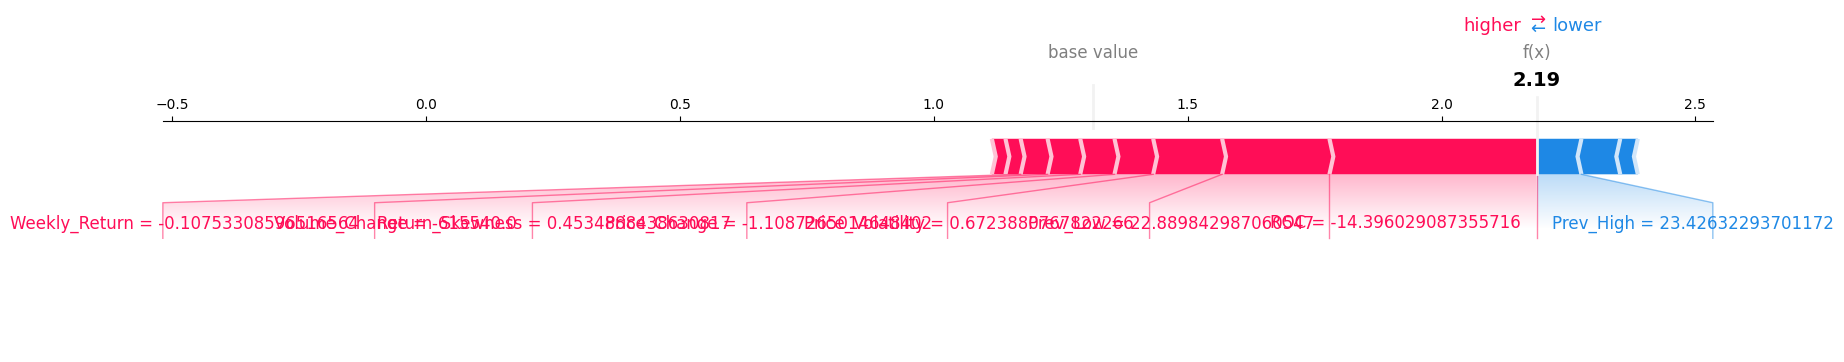

Force plot for sample: 2


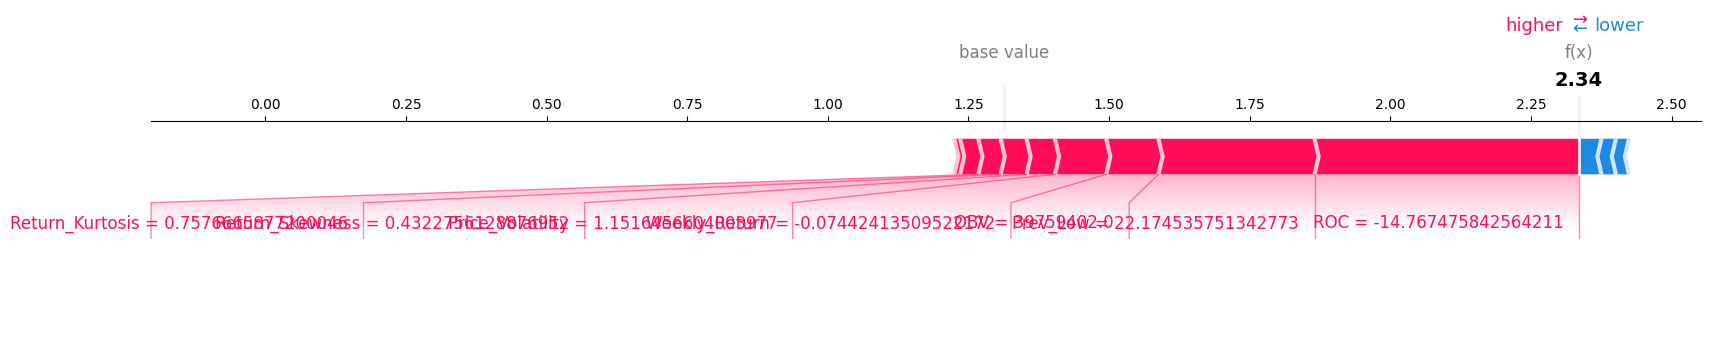

Force plot for sample: 3


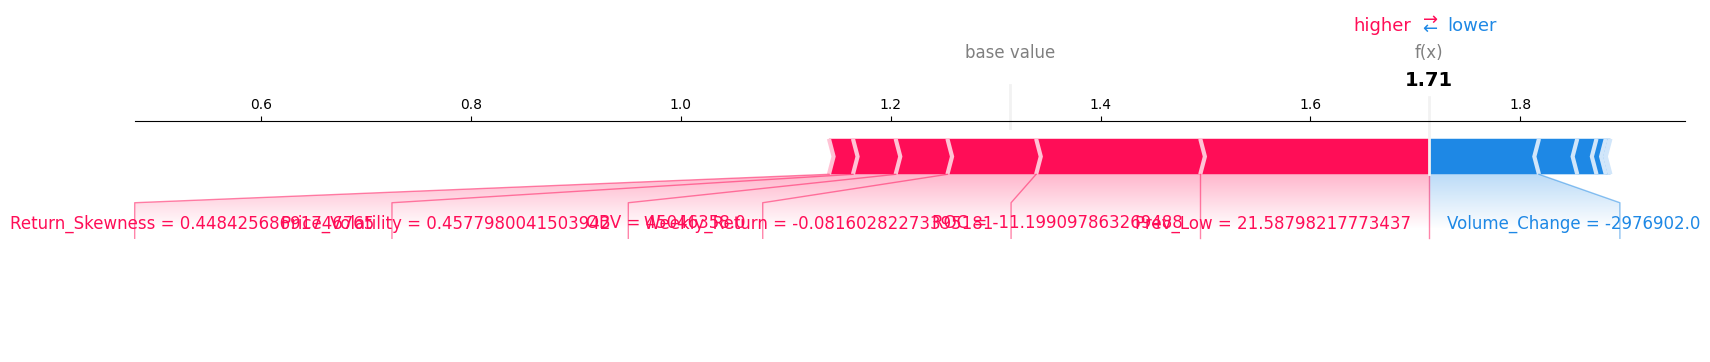

Force plot for sample: 4


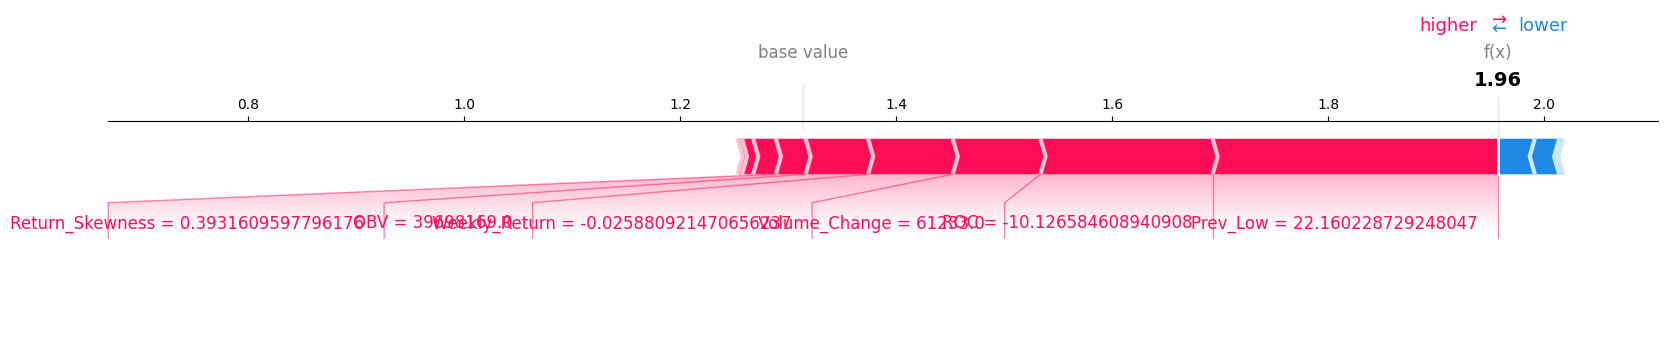

Force plot for sample: 5


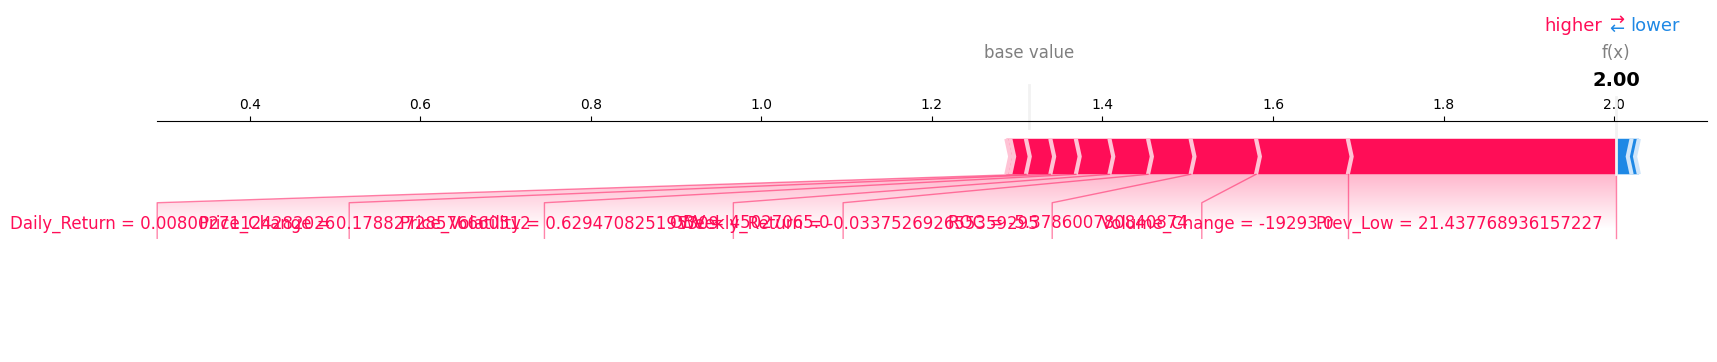

Force plot for sample: 6


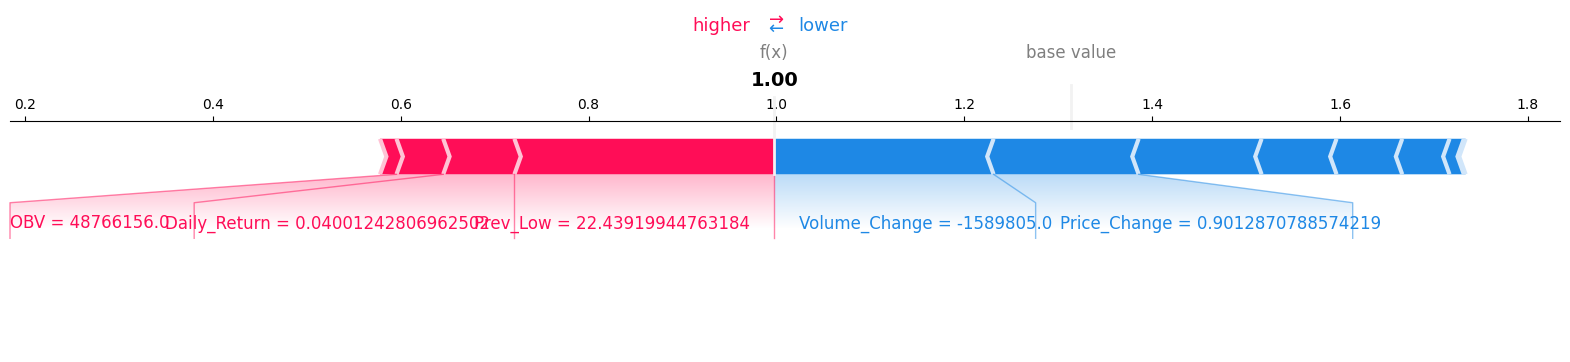

Force plot for sample: 7


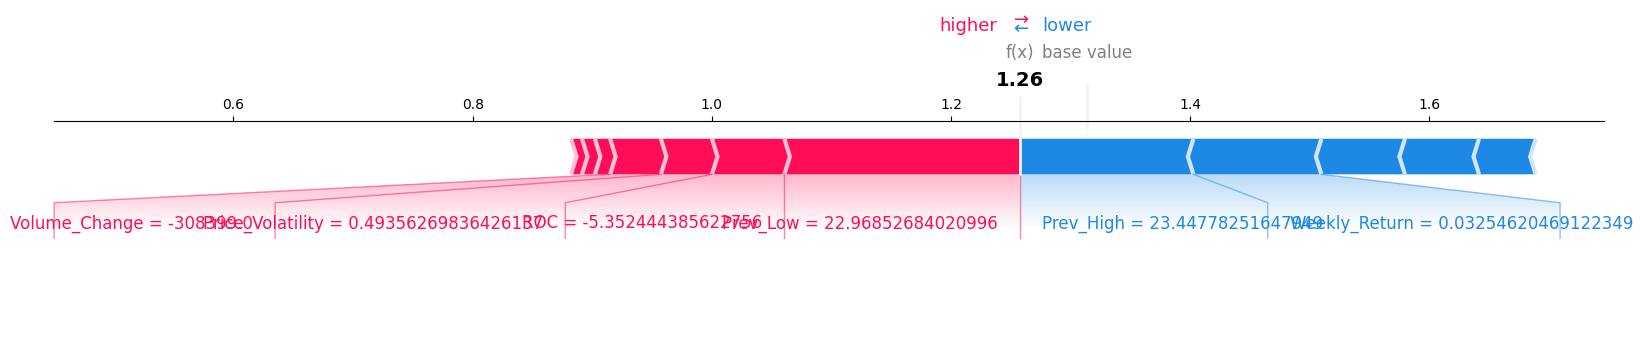

Force plot for sample: 8


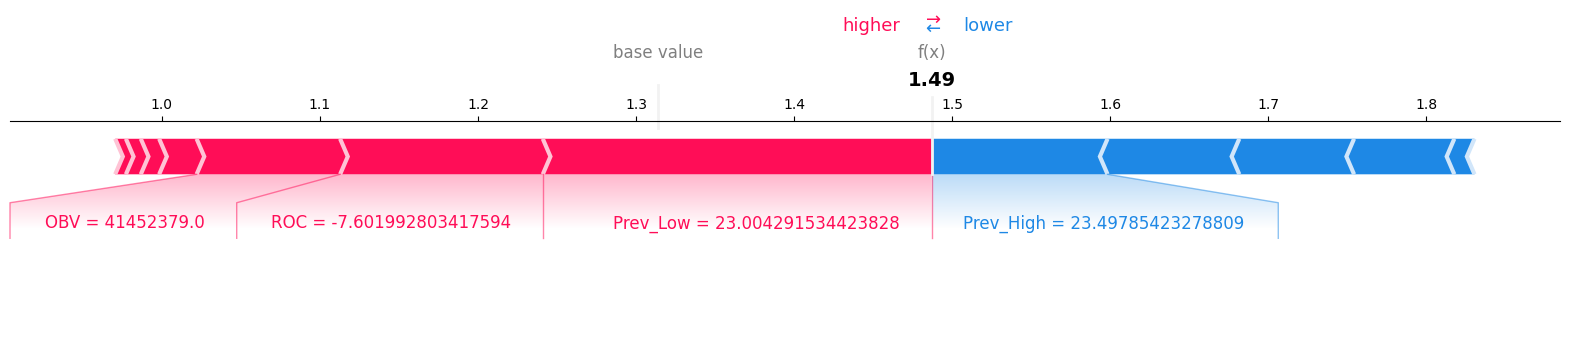

Force plot for sample: 9


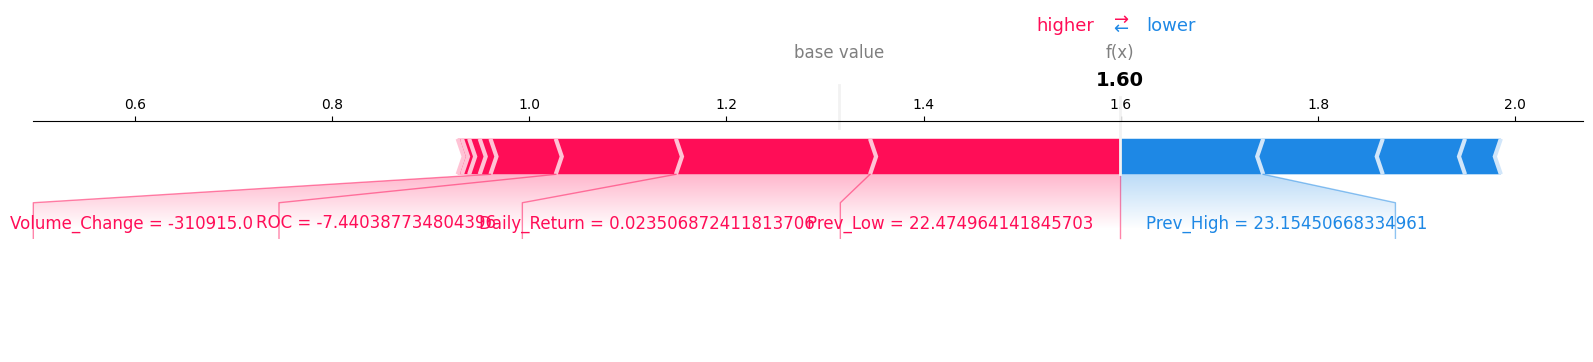

Force plot for sample: 10


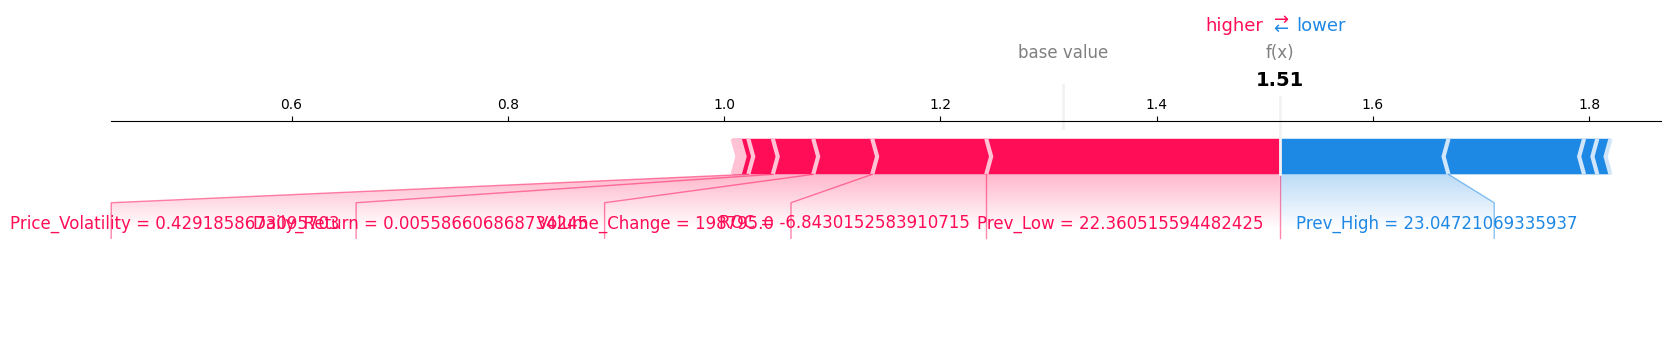

In [35]:
# Select one stock with target equal to one for at least 5 days in a row
symbol = 'VRTX'
df_selected_symbol = df_train[df_train['Symbol'] == symbol]
target_values = df_selected_symbol['Target'].values

# Find indices of samples with target equal to one for at least 5 consecutive days
consecutive_days_indices = np.where(np.convolve(target_values, np.ones(5), mode='valid') == 5)[0]

# If there are such samples, isolate them and 5 samples before them with at least one day with target equal to zero
if len(consecutive_days_indices) > 0:
    selected_indices = []
    for index in consecutive_days_indices:
        if np.any(target_values[index - 5:index] == 0):
            selected_indices.extend(range(index - 5, index + 1))
    
    ten_days_sample = np.array(selected_indices)[[12, 13, 14, 15, 16, 17, 23, 29, 35,41]]
    selected_data = df_selected_symbol.iloc[ten_days_sample][['Date', 'Target']]
    print(selected_data)
    
    # Filter SHAP values and select the chosen samples
    selected_shap_values = shap_values[ten_days_sample]
    selected_X = X_3[ten_days_sample]

    for i in range(len(ten_days_sample)):
        print("Force plot for sample:", i + 1)
        shap.force_plot(explainer.expected_value, selected_shap_values[i], selected_X[i], feature_names=selected_features, matplotlib=True)

else:
    print("No sequence found with at least 5 consecutive days with target equal to one.")

Based on the analysis of the SHAP plots, it's evident that certain features have a significant impact on the model's decision-making process. In the provided 10 samples, features such as *VWAP* and *Prev_High* consistently exhibit the highest magnitudes in the blue arrows, indicating their strong lower influence on the model predictions. Specifically, VWAP appears to have the greatest negative impact, followed by Prev_High. Moreover, in 8 out of 10 samples, the magnitudes of features in the blue arrows surpass those in the red arrows.

On the other hand, features like *ROC*, *Price_Volatility*, and *Daily_Return* dominate the red arrows, indicating their contribution to predictions where the model's output differs from the actual target. In 2 out of 10 samples, the magnitudes of these features in the red arrows are higher compared to the blue arrows.

SHAP values provide insights into individual model predictions by quantifying how each feature contributes to the prediction, either positively or negatively. They represent deviations from a base value, which in this case is 1.3, reflecting the expected value of the target. The function f(x) represents the actual prediction made by the model for that particular feature combination.


###  Predictions for 10 days sample data

In [36]:
# Generating 10 days used for shap 
X_test_selected = df_selected_symbol.iloc[ten_days_sample][selected_features].values

# Predicting target values for selected samples
predictions_selected = best_model_cros_valid_three.predict(X_test_selected)

# Printing actual and predicted target values
for i, pred in enumerate(predictions_selected):
    print(f"Real value: {selected_data['Target'].iloc[i]}, Predicted value: {pred}")


Real value: 1, Predicted value: 1
Real value: 1, Predicted value: 1
Real value: 1, Predicted value: 1
Real value: 1, Predicted value: 1
Real value: 0, Predicted value: 1
Real value: 1, Predicted value: 1
Real value: 1, Predicted value: 1
Real value: 1, Predicted value: 1
Real value: 1, Predicted value: 1
Real value: 1, Predicted value: 1


Based on the output, it seems that the algorithm did not accurately predict all samples. 

Specifically, there is a discrepancy where the actual value is 0, but the predicted value is 1.

### Plotting signals used for 10 days where one stock with target equal to one for at least 5 days in a row and and 5 samples before it with at least one day with target equal to zero

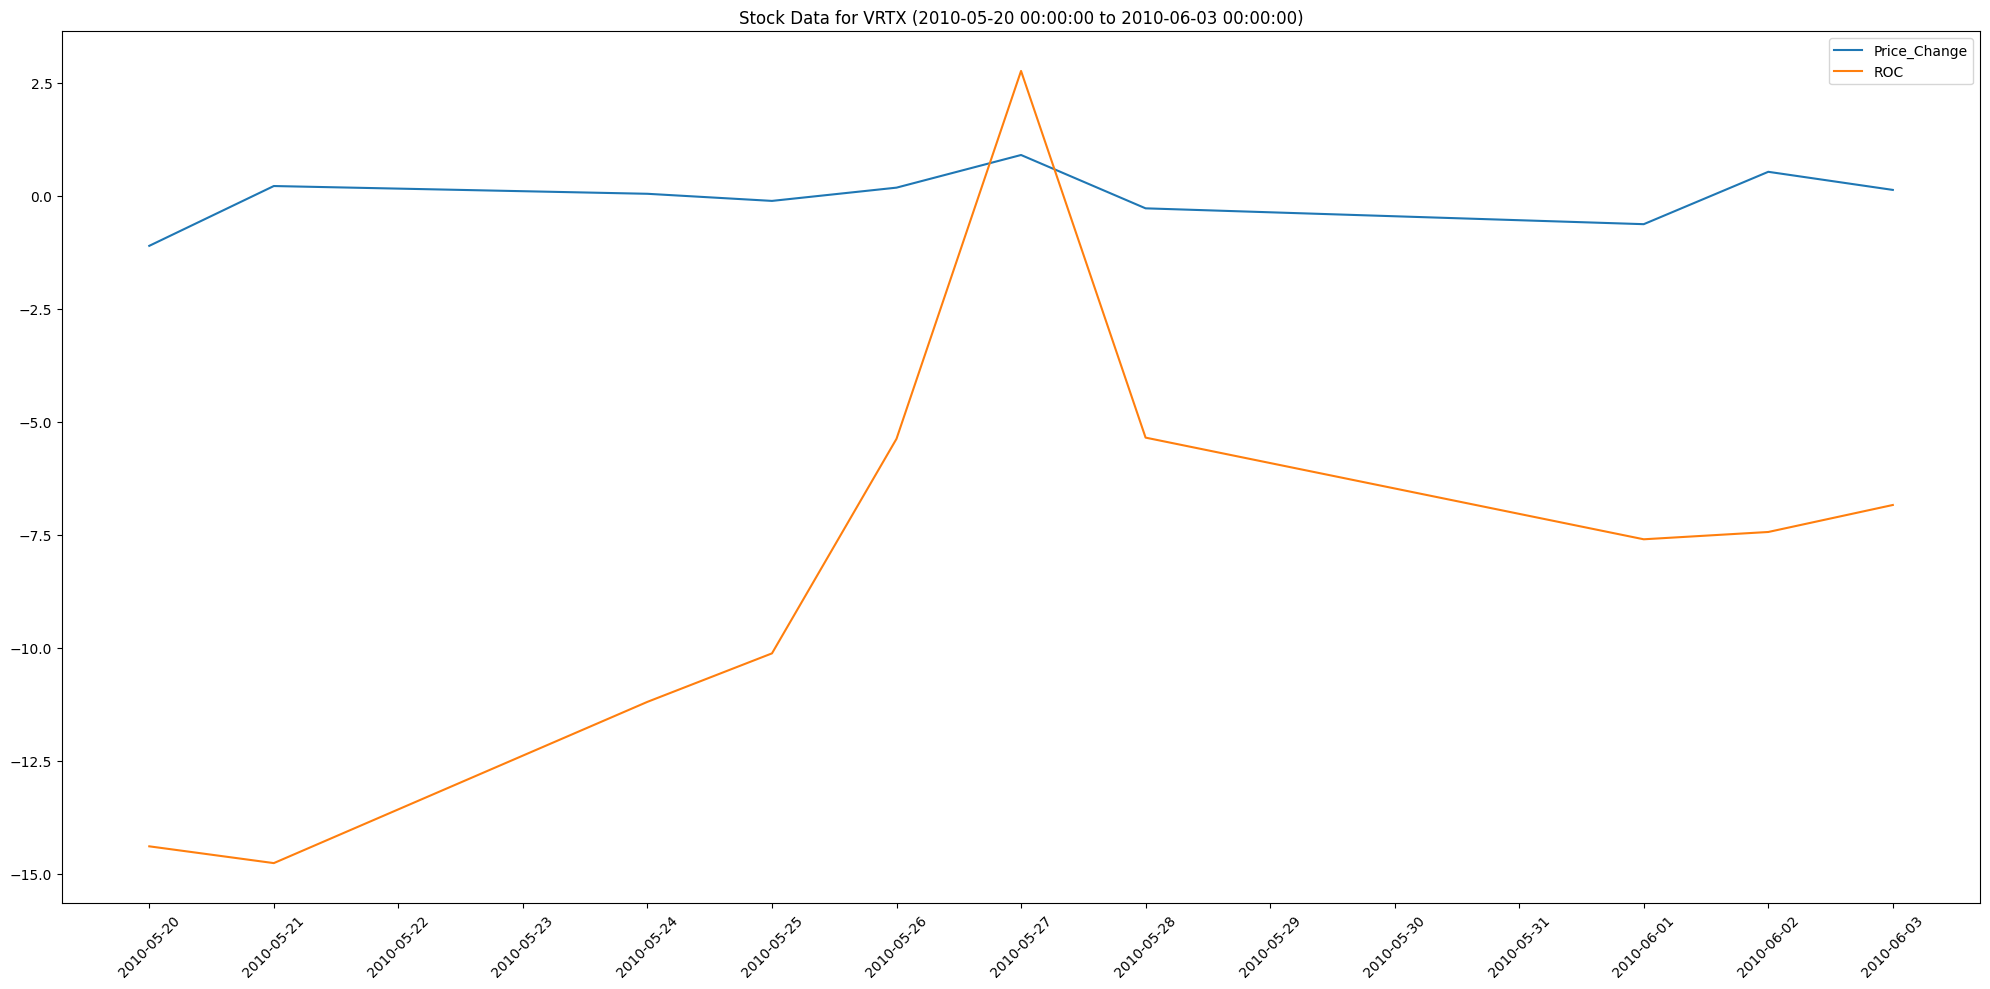

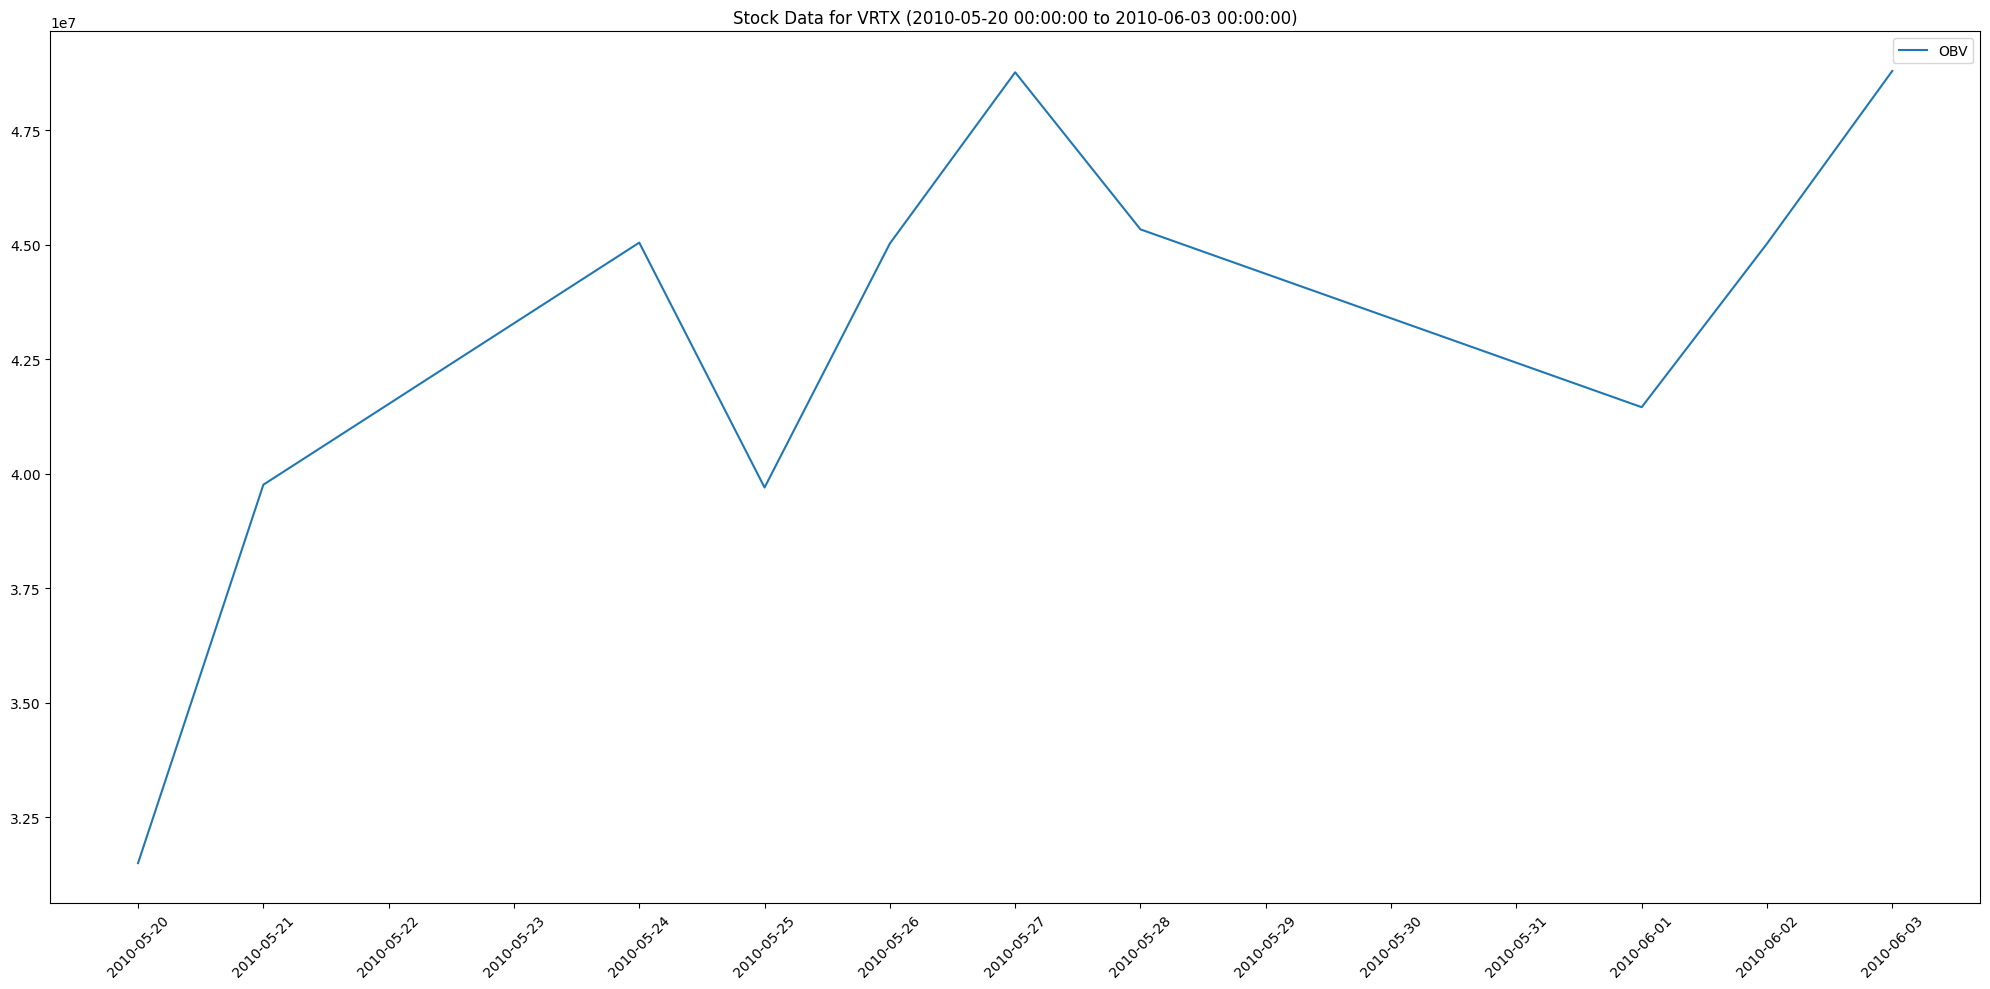

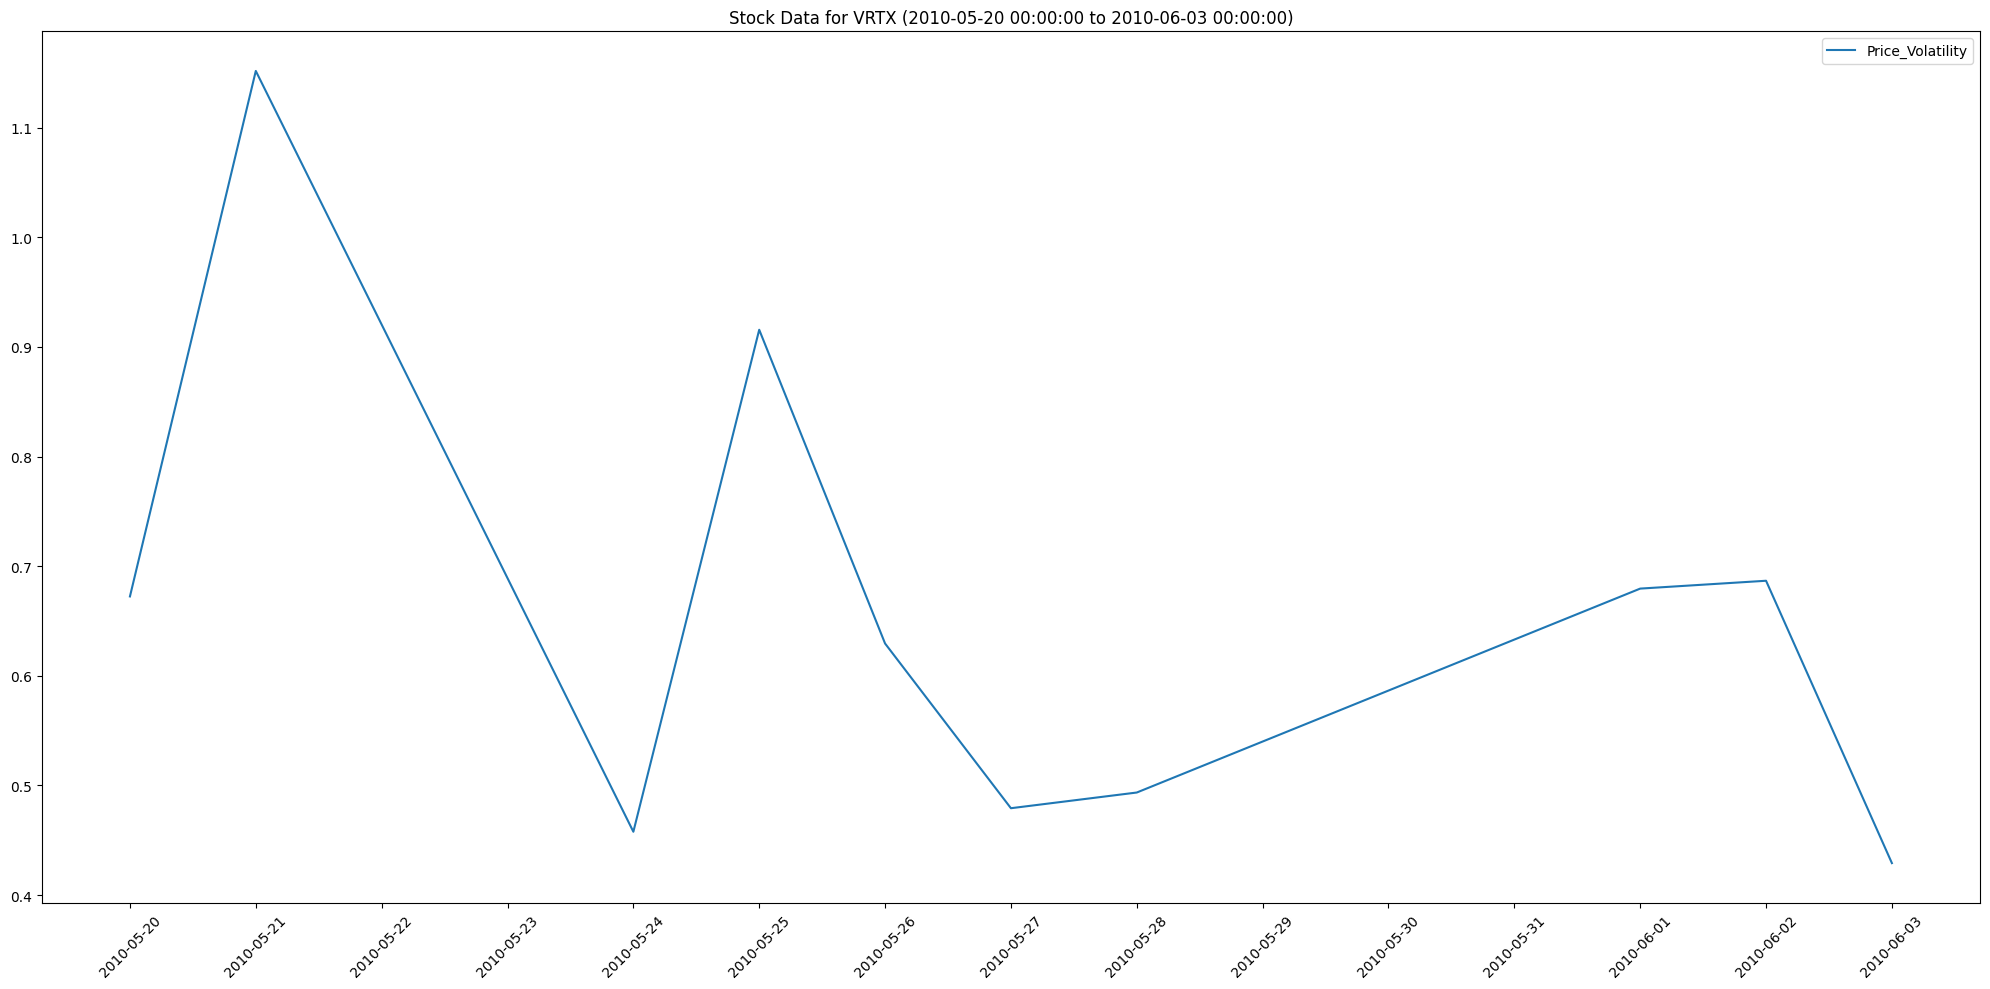

In [37]:
stock_data = df_train.iloc[ten_days_sample]

plot_stock_data(stock_data=stock_data, 
                features=['Price_Change', 'ROC'], 
                stock_name=symbol)
plot_stock_data(stock_data=stock_data, 
                    features=['OBV'], 
                    stock_name=symbol)
plot_stock_data(stock_data=stock_data, 
                    features=['Price_Volatility'], 
                    stock_name=symbol)

# RIPPER optimization

In [38]:
# Select one stock for analysis
symbol = 'VRTX'
df_selected_symbol = df_train[df_train['Symbol'] == symbol]

# Split the data into training and testing sets
X = df_selected_symbol[selected_features].values
y = df_selected_symbol['Target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [39]:
# Train the RIPPER model
ripper_model = lw.RIPPER()
ripper_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = ripper_model.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, predictions)

print("F1 Score:", f1)

# Print the rules learned by the RIPPER algorithm
print("Rules:")
print(ripper_model.ruleset_.out_pretty())

F1 Score: 0.6896551724137931
Rules:
[[1=<38.54] V
[2=102.64-123.22 ^ 0=-71680660.0--58919580.0] V
[0=<-84043620.0 ^ 2=54.52-76.0] V
[0=-84043620.0--71680660.0 ^ 1=78.25-87.93] V
[2=152.35-173.59 ^ 0=>6181160.0] V
[9=67.56-73.91 ^ 1=108.29-127.0] V
[2=44.18-54.52 ^ 9=43.72-49.26] V
[10=0.4-0.69 ^ 0=-14693620.0--6972180.0] V
[10=0.4-0.69 ^ 0=-26003360.0--14693620.0] V
[9=73.91-81.99 ^ 0=-14693620.0--6972180.0] V
[2=84.94-102.64 ^ 9=49.26-55.24] V
[11=>3.94 ^ 0=-26003360.0--14693620.0] V
[9=67.56-73.91 ^ 2=84.94-102.64] V
[2=>173.59 ^ 10=>1.19] V
[10=0.089-0.24 ^ 9=>81.99]]
None


The rules learned by the RIPPER algorithm provide insights into the decision-making process based on the selected features which are
* 0: 'OBV',
* 1: 'Prev_Close',
* 2: Prev_High',
* 3: 'Prev_Low',
* 4: 'Price_Change',
* 5: 'Daily_Return',
* 6: 'Weekly_Return', 
* 7: 'Price_Volatility',
* 8: 'ROC',
* 9: 'VWAP',
* 10: 'Return_Skewness',
* 11: 'Return_Kurtosis':

Here are the interpretations for all the rules provided:
1. [2=<38.54]: If the value of the 'OBV' feature is less than or equal to 38.54, the prediction is positive.
2. [1=104.73-125.03 ^ 0=-71680660.0--58919580.0]: If the 'Prev_Close' feature is between 104.73 and 125.03, and the 'OBV' feature is between -71680660.0 and -58919580.0, the prediction is positive.
3. [0=<-84043620.0 ^ 1=55.49-77.34 ^ 9=49.26-55.24]: If the 'OBV' feature is less than or equal to -84043620.0, the 'Prev_Close' feature is between 55.49 and 77.34, and the 'ROC' feature is between 49.26 and 55.24, the prediction is positive.
4. [0=-84043620.0--71680660.0 ^ 2=78.25-87.93]: If the 'OBV' feature is between -84043620.0 and -71680660.0, and the 'Prev_High' feature is between 78.25 and 87.93, the prediction is positive.
5. [9=67.56-73.91 ^ 0=-26003360.0--14693620.0]: If the 'ROC' feature is between 67.56 and 73.91, and the 'OBV' feature is between -26003360.0 and -14693620.0, the prediction is positive.
6. [1=154.02-175.58 ^ 0=>6181160.0]: If the 'Prev_Close' feature is between 154.02 and 175.58, and the 'OBV' feature is greater than or equal to 6181160.0, the prediction is positive.
7. [9=73.91-81.99 ^ 0=-14693620.0--6972180.0]: If the 'ROC' feature is between 73.91 and 81.99, and the 'OBV' feature is between -14693620.0 and -6972180.0, the prediction is positive.
8. [0=-44094140.0--36386500.0 ^ 1=104.73-125.03]: If the 'OBV' feature is between -44094140.0 and -36386500.0, and the 'Prev_Close' feature is between 104.73 and 125.03, the prediction is positive.
9. [2=45.93-56.65 ^ 9=43.72-49.26]: If the 'Prev_High' feature is between 45.93 and 56.65, and the 'ROC' feature is between 43.72 and 49.26, the prediction is positive.
10. [2=87.93-108.29 ^ 9=49.26-55.24]: If the 'Prev_High' feature is between 87.93 and 108.29, and the 'ROC' feature is between 49.26 and 55.24, the prediction is positive.
11. [0=<-84043620.0 ^ 1=55.49-77.34]: If the 'OBV' feature is less than or equal to -84043620.0, and the 'Prev_Close' feature is between 55.49 and 77.34, the prediction is positive.
12. [11=>3.94 ^ 0=-26003360.0--14693620.0]: If the 'Return_Kurtosis' feature is greater than or equal to 3.94, and the 'OBV' feature is between -26003360.0 and -14693620.0, the prediction is positive.


## Using Grid Search to find best hyperparameter for Ripper

In [40]:
# Define the parameter grid
param_grid = {
    'k': [1, 3, 5, 8],                  # Number of RIPPER optimization iterations
    'prune_size': [0.2, 0.4,0.6, 0.8],   # Proportion of the training set to be used for pruning
    'dl_allowance': [0.1, 0.5, 0.7 ,1.0]  # Description length allowance
}

# Initialize the RIPPER model
ripper_model_optimal = lw.RIPPER()

# Initialize GridSearchCV with the RIPPER model and parameter grid
grid_search = GridSearchCV(estimator=ripper_model_optimal, param_grid=param_grid, cv=5, scoring='f1')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)

Best Parameters: {'dl_allowance': 1.0, 'k': 5, 'prune_size': 0.2}
Best F1 Score: 0.5766128474684011


In [41]:
# Initialize the RIPPER model with the best parameters
ripper_model_optimal = lw.RIPPER(**best_params)

# Fit the RIPPER model with the best parameters to the training data
ripper_model_optimal.fit(X_train, y_train)

# Print the rules learned by the optimized RIPPER model
print("Rules:")
print(ripper_model_optimal.ruleset_.out_pretty())

Rules:
[[1=<38.54 ^ 6=<0.96 ^ 0=-44094140.0--36386500.0] V
[10=0.4-0.69 ^ 9=49.26-55.24] V
[1=<38.54 ^ 0=-58919580.0--44094140.0] V
[2=102.64-123.22 ^ 9=67.56-73.91] V
[1=<38.54] V
[9=49.26-55.24 ^ 1=87.93-108.29]]
None


In [42]:
# Initialize the RIPPER model with specified parameters
ripper_model_optimal_max_rules = lw.RIPPER(**best_params, max_rules=3, max_rule_conds=2)

# Fit the RIPPER model with the best parameters and specified parameters to the training data
ripper_model_optimal_max_rules.fit(X_train, y_train)

predictions_3 = ripper_model_optimal_max_rules.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, predictions_3)

print("F1 Score:", f1)

# Print the rules learned by the optimized RIPPER model
print("Rules:")
print(ripper_model_optimal_max_rules.ruleset_.out_pretty())


F1 Score: 0.49662921348314604
Rules:
[[1=<38.54] V
[2=102.64-123.22] V
[10=0.4-0.69]]
None


Optimized RIPPER Model: This model was trained with the best parameters obtained from the grid search. It appears to have more complex rules compared to the model with limited rules. The rules include multiple conditions (up to three conditions) and a wider range of attribute values.

Optimized RIPPER Model with Limited Rules: In contrast, this model was trained with the same best parameters but with additional constraints on the maximum number of rules (max_rules=3) and the maximum number of conditions per rule (max_rule_conds=2). As a result, the rules are simpler, with fewer conditions and a narrower range of attribute values.

There are overlapping rules between the two models. Both models include rules that involve the attribute 1 and especially 2 within certain value ranges, although the specific conditions and accompanying attribute ranges differ slightly between the models. These consistent rules may represent particularly important decision boundaries or patterns in the data that the algorithm consistently identifies as relevant for classification.


It's intriguing to note that the default RIPPER model ripper_model = lw.RIPPER() achieved a higher F1 score compared to ripper_model_optimal = lw.RIPPER(best_params) and ripper_model_optimal_max_rules = lw.RIPPER(best_params, max_rules=3, max_rule_conds=2). This discrepancy suggests that the default settings of the RIPPER algorithm might be more effective for the given dataset than the hyperparameters obtained through grid search or the constrained version with maximum rules and conditions.

## Ripper algorithm


The RIPPER algorithm's performance, measured in terms of F1-score, falls within the range of 0.4457 to 0.7334. On the other hand, the F1-scores obtained from other tested algorithms, including GaussianNB, LogisticRegression, RandomForestClassifier, ExtraTreesClassifier, and XGBClassifier, range from 0.88 to 0.93. Therefore, it is evident that RIPPER yields inferior results compared to the other tested algorithms.

Regarding the advantages and disadvantages of the RIPPER algorithm:

**Advantages**:
* **Interpretability**: RIPPER produces human-readable rules that provide insights into the decision-making process of the model, enhancing interpretability.
* **Handling of Noisy Data**: It can handle noisy data well due to its rule-based nature, making it suitable for datasets with imperfect data.
* **Feature Selection**: The algorithm implicitly performs feature selection by identifying the most discriminative features for classification. This can lead to simpler and more interpretable models.
* **Efficiency**: RIPPER typically has low computational complexity, making it computional efficient for large datasets.

**Disadvantages**:
* **Binary Attributes**: RIPPER works best with datasets containing binary attributes or attributes that can be discretized into binary values. It may not perform as well with continuous or high-dimensional data.
* **Overfitting**: Like other rule-based algorithms, RIPPER is prone to overfitting, especially when the number of rules is not properly controlled.
* **Sensitivity to Parameters**: The performance of RIPPER can depend heavily on the choice of parameters such as the number of iterations, pruning size, and description length allowance. Selecting optimal parameters can be challenging and time-consuming.
* **Limited Expressiveness**: RIPPER's expressiveness is limited by the rule format, which may not capture complex decision boundaries as effectively as other algorithms like decision trees or neural networks.
* **Imbalanced Data**: RIPPER may not perform well on imbalanced datasets where one class is much more prevalent than others. It might struggle to learn rules for minority classes effectively.